In [1]:
import pandas as pd
import os
from datetime import date, timedelta
import datetime
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
import altair as alt
from mpl_toolkits.basemap import Basemap
#import pillow
#import geopandas
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

C:\Users\paull\Anaconda32\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#pip install basemap-data-hires

In [23]:
org = os.path.join(ROOT_DIR, 'data', 'data','weatherAA.pkl')
bad = os.path.join(ROOT_DIR, 'data','badAAcleaned.pkl')
clean = os.path.join(ROOT_DIR, 'data','AAcleaned.pkl')


In [24]:
df_org=pd.read_pickle(org)
df_bad=pd.read_pickle(bad)
df_cln=pd.read_pickle(clean)
df_bad.set_index('time',inplace=True)

### Cleaning - issues with Polynomial

In [25]:
time_range = pd.date_range('2006-01-01 00:00:00','2022-09-22 22:00:00', freq='H') #'2022-10-15 23:00:00', freq='H') ##creating time range
time_range=pd.DataFrame(time_range, columns=['time'])
time_range.set_index('time',inplace=True)
df_org=time_range.merge(df_org,how='left',left_index=True,right_index=True)
df_org['data']='Original'
df_bad['data']='Polynomial'
df_cln['data']='SARIMA'

In [26]:
df_cln

,temp,dwpt,rhum,prcp,wdir,wspd,pres,NaNcount,NaNmax,data
time,,,,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,NaN,240.0,14.8,NaN,0,0.0,SARIMA
2006-01-01 01:00:00,1.1,-0.1,92.0,0.0,240.0,14.8,1009.0,0,0.0,SARIMA
2006-01-01 02:00:00,0.6,0.0,96.0,NaN,250.0,13.0,1009.5,0,0.0,SARIMA
2006-01-01 03:00:00,1.1,-0.1,92.0,NaN,250.0,13.0,1009.6,0,0.0,SARIMA
2006-01-01 04:00:00,1.1,-0.7,88.0,NaN,250.0,14.8,1010.5,0,0.0,SARIMA
...,...,...,...,...,...,...,...,...,...,...
2022-09-22 18:00:00,16.0,4.4,46.0,0.0,340.0,20.0,1017.0,0,0.0,SARIMA
2022-09-22 19:00:00,15.0,3.5,46.0,0.0,320.0,25.9,1017.6,0,0.0,SARIMA
2022-09-22 20:00:00,16.1,4.5,46.0,0.0,320.0,18.4,1017.9,0,0.0,SARIMA


In [27]:
df_cln_graph=pd.concat([df_org.loc['2006-04-07 12:00:00':'2006-04-12 00:00:00'][['temp','data']],df_bad.loc['2006-04-09 04:00:00':'2006-04-10 16:00:00'][['temp','data']],df_cln.loc['2006-04-09 04:00:00':'2006-04-10 16:00:00'][['temp','data']]])

In [208]:
range_=['cornflowerblue','red','green']
domain = ['Original','Polynomial','SARIMA']
alt.Chart(df_cln_graph.reset_index(), height=400, width=800).mark_circle().encode(
alt.X('time',title=None),
alt.Y('temp', axis=alt.Axis(title='Temperature (°C)')
     ),
color=alt.Color('data',legend=alt.Legend(title='Interpolation'), scale=alt.Scale(domain=domain, range=range_)
                )
).properties(
    height=400,
    width=750,
    title={
      "text": ['Figure 3: Interpolation Example on Original Data'], 
      "subtitle": ["Ann Arbor only April 7, 2006 - Apirl 12, 2006"],
      "color": "black",
      "subtitleColor": "gray"
    }
).configure_title(
    fontSize=20,
    subtitleFontSize=16
).configure_axisY(
    labelFontSize=16,
    titleFontSize=18,
    gridOpacity=.4
).configure_axisX(
    labelFontSize=16,
    titleFontSize=18,
    gridOpacity=.4
).configure_legend(
titleFontSize=18,
labelFontSize=15
) 



alt.Chart(...)

In [40]:
maplocations = os.path.join(ROOT_DIR, 'unsupervised_models','kmeansclustering2.csv')
k_means_location=pd.read_csv(maplocations)

In [70]:
kmeans=k_means_location.iloc[0:26]

In [71]:
kmeans

,Unnamed: 0,station,total,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,milesfromstat
0,206,KARB0,8736,KARB0,Ann Arbor / Pittsfield,US,MI,NaN,KARB,42.2230,-83.7456,256.0,America/Detroit,2006-01-01,2022-09-22,2006-01-01,2022-04-24,2006-01-01,2022-01-01,0.000000
1,416,KMML0,6432,KMML0,Marshall,US,MN,NaN,KMML,44.4517,-95.8244,361.0,America/Chicago,2006-01-01,2022-09-22,2006-01-01,2022-04-24,2008-01-01,2022-01-01,627.132888
2,325,KGAF0,5348,KGAF0,Grafton,US,ND,NaN,KGAF,48.4047,-97.3709,251.0,America/Chicago,2010-11-18,2022-09-22,2010-11-19,2022-04-24,2014-01-01,2022-01-01,787.526654
3,323,KFSW0,5323,KFSW0,Fort Madison / Summit (Historical),US,IA,NaN,KFSW,40.6593,-91.3268,220.0,America/Chicago,2006-01-03,2022-09-22,2006-01-05,2022-04-24,2014-01-01,2021-01-01,408.045768
4,208,KARV0,5320,KARV0,Minocqua / Woodruff,US,WI,NaN,KARV,45.9279,-89.7309,497.0,America/Chicago,2006-01-01,2022-09-22,2006-01-01,2022-04-24,2009-01-01,2022-01-01,392.465081
5,422,KMQB0,5304,KMQB0,Macomb / Good Hope,US,IL,NaN,KMQB,40.5201,-90.6524,215.0,America/Chicago,2006-02-01,2022-09-22,2006-02-15,2022-04-24,2012-01-01,2022-01-01,377.657133
6,418,KMNN0,5278,KMNN0,Marion / Logan (Historical),US,OH,NaN,KMNN,40.6163,-83.0635,303.0,America/New_York,2006-01-01,2022-09-22,2006-01-01,2022-04-21,2006-01-01,2022-01-01,116.402149
7,520,KTNU0,5264,KTNU0,Newton / Coal Siding (Historical),US,IA,NaN,KTNU,41.6744,-93.0217,291.0,America/Chicago,2006-01-01,2022-09-22,2006-01-01,2022-04-24,2011-01-01,2022-01-01,479.185382
8,524,KTVC0,5247,KTVC0,Traverse City / Treverse City [Misspelling] / ...,US,MI,NaN,KTVC,44.7416,-85.5824,190.0,America/Detroit,1973-01-01,2022-09-22,1973-01-02,2022-04-24,1981-01-01,2022-01-01,196.855534
9,85,72420,5216,72420,Mansfield / Amoy,US,OH,72420.0,KMFD,40.8214,-82.5166,395.0,America/New_York,2005-01-01,2022-09-22,1948-08-01,2022-09-14,1948-01-01,2022-01-01,115.837645


In [106]:
dbscan=np.array(['0CO7B',
  '0FV1F',
  '4DUJO',
  '5RUZT',
  '6N2T2',
  '71283',
  '71298',
  '71307',
  '71352',
  '71368',
  '71527',
  '71538',
  '71623',
  '71631',
  '71633',
  '71634',
  '71704',
  '72420',
  '72428',
  '72520',
  '72521',
  '72525',
  '72526',
  '72530',
  '72533',
  '72535',
  '72536',
  '72537',
  '72539',
  '72543',
  '72545',
  '72634',
  '72635',
  '72636',
  '72637',
  '72638',
  '72643',
  '72645',
  '7Q717',
  '8HNVP',
  '93RHE',
  '9H92X',
  'ATA0X',
  'FO7ZN',
  'GUUD7',
  'K7B4X',
  'KADG0',
  'KAEL0',
  'KAIO0',
  'KAKR0',
  'KAMN0',
  'KANQ0',
  'KAOH0',
  'KARB0',
  'KARR0',
  'KASW0',
  'KAUM0',
  'KAXV0',
  'KAZO0',
  'KBEH0',
  'KBIV0',
  'KBJJ0',
  'KBTL0',
  'KC290',
  'KC350',
  'KC620',
  'KC650',
  'KCFS0',
  'KCGF0',
  'KCNB0',
  'KCNC0',
  'KD950',
  'KDET0',
  'KDFI0',
  'KDKB0',
  'KDLL0',
  'KDPA0',
  'KEDJ0',
  'KEFT0',
  'KEKM0',
  'KENW0',
  'KETB0',
  'KFBL0',
  'KFFL0',
  'KFFX0',
  'KFKA0',
  'KFLD0',
  'KFPK0',
  'KFXY0',
  'KGGI0',
  'KGKJ0',
  'KGSH0',
  'KGUS0',
  'KGWB0',
  'KGYL0',
  'KGYY0',
  'KHAI0',
  'KHHG0',
  'KHPT0',
  'KHYX0',
  'KHZY0',
  'KI750',
  'KIFA0',
  'KIGQ0',
  'KIIB0',
  'KIKK0',
  'KIKV0',
  'KIKW0',
  'KIRS0',
  'KISW0',
  'KJVL0',
  'KJXN0',
  'KJYM0',
  'KLDM0',
  'KLNN0',
  'KLOT0',
  'KLPR0',
  'KLWA0',
  'KMBL0',
  'KMBS0',
  'KMCX0',
  'KMFI0',
  'KMGC0',
  'KMIE0',
  'KMNN0',
  'KMOP0',
  'KMQB0',
  'KMRJ0',
  'KMRT0',
  'KMTW0',
  'KMUT0',
  'KMWM0',
  'KMZZ0',
  'KOEB0',
  'KOOA0',
  'KOSC0',
  'KOSH0',
  'KOSU0',
  'KOWX0',
  'KOXI0',
  'KOZW0',
  'KP580',
  'KPEA0',
  'KPLD0',
  'KPLN0',
  'KPPO0',
  'KPTK0',
  'KPVB0',
  'KPWK0',
  'KRAC0',
  'KRCR0',
  'KRMY0',
  'KRNP0',
  'KRPJ0',
  'KRQB0',
  'KRYV0',
  'KRZL0',
  'KSJX0',
  'KSUE0',
  'KSYN0',
  'KTDZ0',
  'KTEW0',
  'KTNU0',
  'KTTF0',
  'KUGN0',
  'KUNU0',
  'KVES0',
  'KVLL0',
  'KVNW0',
  'KVOK0',
  'KVPZ0',
  'KXNWG',
  'KY700',
  'KYIP0',
  'L6N28',
  'MAU7O',
  'MEIQU',
  'MVZI9',
  'N4N88',
  'O879F'])

In [107]:
station_loc = os.path.join(ROOT_DIR, 'station_analysis','AAstation.csv') #station data to get distance for comparision
dfstations=pd.read_csv(station_loc)
dbscan=pd.DataFrame(dbscan)

In [108]:
dbscan=dfstations.merge(dbscan, how='inner', left_on='id', right_on=0)

In [109]:
dbscan

,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,milesfromstat,0
0,0CO7B,Kingsville Moe,CA,ON,NaN,NaN,42.04,-82.67,200.0,America/Toronto,NaN,NaN,2000-01-01,2022-09-17,2000-01-01,2021-01-01,56.683564,0CO7B
1,0FV1F,Tillsonburg Wwtp,CA,ON,NaN,NaN,42.86,-80.72,213.0,America/Toronto,NaN,NaN,2000-01-01,2022-09-18,2000-01-01,2021-01-01,160.560157,0FV1F
2,4DUJO,Fergus Shand Dam,CA,ON,NaN,NaN,43.73,-80.33,418.0,America/Toronto,NaN,NaN,2000-01-01,2022-09-18,2000-01-01,2022-01-01,201.949443,4DUJO
3,5RUZT,Woodstock,CA,ON,NaN,NaN,43.14,-80.77,282.0,America/Toronto,NaN,NaN,2000-01-01,2022-09-09,2000-01-01,2006-01-01,164.217123,5RUZT
4,6N2T2,Chatham Wpcp,CA,ON,NaN,NaN,42.39,-82.22,180.0,America/Toronto,NaN,NaN,2000-01-01,2019-02-20,2000-01-01,2006-01-01,79.005726,6N2T2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,MAU7O,Mono Centre,CA,ON,71098.0,NaN,44.03,-80.02,436.0,America/Toronto,2020-01-01,2022-09-21,2013-11-19,2022-09-19,2013-01-01,2022-01-01,225.897607,MAU7O
176,MEIQU,Amherstburg,CA,ON,NaN,NaN,42.10,-83.09,182.0,America/Toronto,NaN,NaN,2000-01-01,2022-09-17,2000-01-01,2022-01-01,34.719307,MEIQU
177,MVZI9,Brantford Airport,CA,ON,71602.0,NaN,43.14,-80.33,246.0,America/Toronto,2020-01-01,2022-09-21,2014-12-12,2022-09-19,2015-01-01,2022-01-01,185.091074,MVZI9
178,N4N88,Thornbury 3,CA,ON,NaN,NaN,44.55,-80.47,212.0,America/Toronto,NaN,NaN,2006-05-01,2022-09-17,2006-01-01,2022-01-01,230.191411,N4N88


In [110]:
#pip list

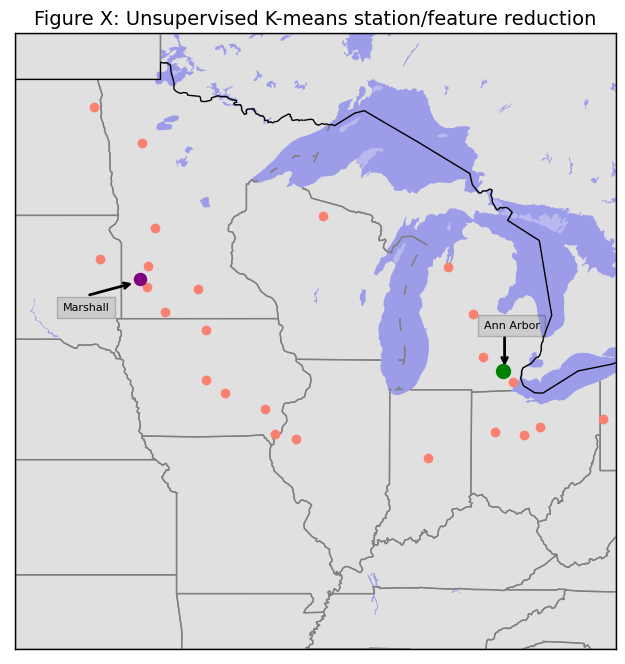

In [213]:
# merc
lat = kmeans['latitude'].values
long= kmeans['longitude'].values

fig = plt.figure(figsize=(8, 8))
m=Basemap(llcrnrlon=-100, llcrnrlat=35, urcrnrlon=-80.,urcrnrlat=50, projection='merc', resolution='i')
m.drawmapboundary(fill_color='lightgrey')
m.fillcontinents(color='white', alpha=0.3, lake_color='blue')
m.drawstates(color='grey', linewidth=1)
m.drawcountries(color='black', linewidth=1)
aalons,aalats=m(-83.7456,42.2230)
dlons,dlats=m(-95.8244,44.4517)
# convert lat and long to map projection coordinates
lons, lats = m(long, lat)

m.scatter(lons, lats, marker = 'o', color='salmon',  zorder=5)
m.scatter(aalons, aalats, marker = 'o', color='green', s=100, zorder=5)
m.scatter(dlons, dlats, marker = 'o', color='purple', s=75, zorder=6)
plt.annotate('Ann Arbor', xy=(.78, .52), xycoords='axes fraction',bbox=dict(facecolor='grey',alpha=0.2),fontsize=8)
plt.annotate('',xy=(.815,.455), xytext=(.815,.51),xycoords='axes fraction',arrowprops=dict(arrowstyle="->",linewidth=2))

plt.annotate('Marshall', xy=(.08, .55), xycoords='axes fraction',bbox=dict(facecolor='grey',alpha=0.2),fontsize=8)
plt.annotate('',xy=(.2,.595), xytext=(.12,.574),xycoords='axes fraction',arrowprops=dict(arrowstyle="->",linewidth=2))
plt.title('Figure X: Unsupervised K-means station/feature reduction', fontsize=14) 
plt.show()

In [181]:
station_loc = os.path.join(ROOT_DIR, 'data','fullstationlist.csv') #station data to get distance for comparision
dfstationsfull=pd.read_csv(station_loc)

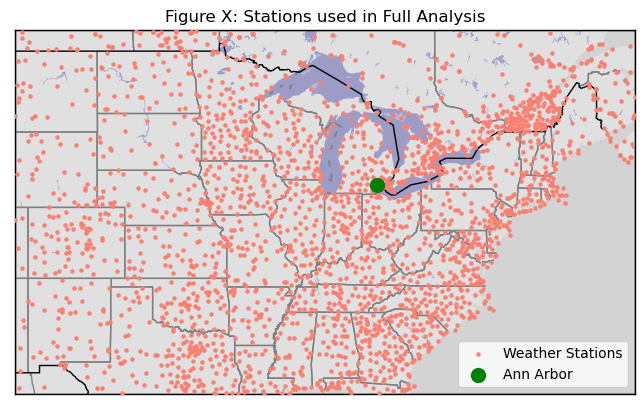

In [196]:
lat = dfstationsfull['latitude'].values
long= dfstationsfull['longitude'].values
((50, -110), (30, -65))
fig = plt.figure(figsize=(8, 8))
m=Basemap(llcrnrlon=-110, llcrnrlat=30, urcrnrlon=-65.,urcrnrlat=50, projection='merc', resolution='i')
m.drawmapboundary(fill_color='lightgrey')
m.fillcontinents(color='white', alpha=0.3, lake_color='darkblue')
m.drawstates(color='grey', linewidth=1)
m.drawcountries(color='black', linewidth=1)
aalons,aalats=m(-83.7456,42.2230)
dlons,dlats=m(-95.8244,44.4517)
# convert lat and long to map projection coordinates
lons, lats = m(long, lat)
aalons,aalats=m(-83.7456,42.2230)

m.scatter(lons, lats, marker = 'o', color='salmon', s=5, zorder=5, label='Weather Stations')
AA=m.scatter(aalons, aalats, marker = 'o', color='green', s=100, zorder=5, label='Ann Arbor')
plt.title('Figure X: Stations used in Full Analysis') 
plt.legend()
plt.show()

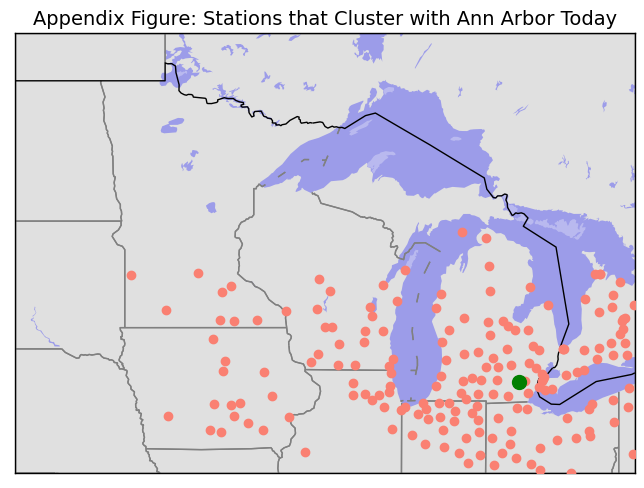

In [216]:
dbscanlat = dbscan['latitude'].values
dbscanlong= dbscan['longitude'].values

fig = plt.figure(figsize=(8, 8))
m=Basemap(llcrnrlon=-100, llcrnrlat=40, urcrnrlon=-80.,urcrnrlat=50, projection='merc', resolution='i')
m.drawmapboundary(fill_color='lightgrey')
m.fillcontinents(color='white', alpha=0.3, lake_color='blue')
m.drawstates(color='grey', linewidth=1)
m.drawcountries(color='black', linewidth=1)
aalons,aalats=m(-83.7456,42.2230)
#dlons,dlats=m(-95.8244,44.4517)
# convert lat and long to map projection coordinates
lons, lats = m(dbscanlong, dbscanlat)

m.scatter(lons, lats, marker = 'o', color='salmon',  zorder=5)
m.scatter(aalons, aalats, marker = 'o', color='green', s=100, zorder=5)
plt.title('Appendix Figure: Stations that Cluster with Ann Arbor Today', fontsize=14) 
#m.scatter(dlons, dlats, marker = 'o', color='purple', s=75, zorder=6)
plt.show()